<h1>Challenge 3: Anomaly detection</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>May 2019</i>

## Summary
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Introduction
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

In this notebook we explore an anomaly detection (AD) problem. AD refers to the refers to the process of detecting data points that do not conform with the rest of observations. Usually AD implies an unsupervised learning problem, however we will approach the problem in a slightly different manner. 

We will be using data generated by an IT monitoring system. The input data has 36 columns, and the aim is to predict the outcome of 8 different "checks" (anomalies). A big challenge in this task has been handling missing data in the dataset, and the uneven distribution of anomalies versus "regular observations", but this are very typical problems in AD. 

In this notebook we will explore the distribution of the data we are working on, explore the missing data in the input data, and in the "checks" we will try to predict. We will discuss a couple of ways of dealing with missing data. We will explore one rule-based model, that generates rules from training data, that is later used to predict the outcome of the test data. We will explore two different machine learning models. One using an ensamble of single-label classification models and one multilabel classification model. 

The models will be compared with the following metrics
* Predictive performance
* Interpretability
* Time it takes to train model

Finally we will explore if further hyper-parameter optimization is beneficial, and evaluate our chosen model based XXX and assess the YY of our model. 

## Data exploration
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Importing libraries and fetching data

In [2]:
# Elementary
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
from tqdm import tqdm

# For elementary data manipulation
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataframe and cast names
from names import column_names, labels
basepath = "/mnt/datasets/anomaly/"
dataDF = pd.read_csv(basepath + 'data.csv', delimiter=";", header=None, names=column_names)
pure_dataDF = dataDF.drop(labels, axis=1)
anomaliesDF = dataDF.filter(labels, axis=1)

### Exploring the dataset

Let us first inspect what data is missing from the dataset. We first look at the missing data in the label dataframe (anamoliesDF), then the missing data in the input dataframe (pure_dataDF). 

In [33]:
print(anomaliesDF.isna().mean().round(4) * 100, '\n')
data_nan = pure_dataDF.isna().mean().round(4) * 100

nan_cols = []
for index, value in data_nan.iteritems():
    if value > 0:   
        print('{:<27} {:<10}'.format(index, np.round(value,2)))
        nan_cols.append(index)

Check1    8.54
Check2    8.53
Check3    7.86
Check4   12.77
Check5   12.21
Check6    2.57
Check7   12.45
Check8    0.02
dtype: float64 

CPU                         8.78      
PhysMEM                     7.17      
InstanceMEM                 7.71      
TablesAllocation            0.8       
IndexServerAllocationLimit  9.21      
DeltaSize                   0.07      
MergeErrors                 2.69      
BlockingPhaseSec            26.43     
Disk                        3.96      
LargestTableSize            5.66      
LargestPartitionSize        0.05      
DiagnosisFiles              7.64      
DiagnosisFilesSize          7.64      
LogSegmentChange            12.39     


Here we see that three of the checks have up to 13% of the data as NaN, or "missing", which is a lot. In the pure_dataDF there are only 14 columns with missing data, where two of them are missing 12% and 26% respectively, and the rest are missing between 0% and 8%. 

In [44]:
data_nan = pure_dataDF[nan_cols].copy()
data_nan.describe()

,CPU,PhysMEM,InstanceMEM,TablesAllocation,IndexServerAllocationLimit,DeltaSize,MergeErrors,BlockingPhaseSec,Disk,LargestTableSize,LargestPartitionSize,DiagnosisFiles,DiagnosisFilesSize,LogSegmentChange
count,261822.00,266464.00,264914.00,284741.00,260587.00,286825.00,279298.00,211177.00,275652.00,270781.00,286881.00,265108.00,265108.00,251482.00
mean,12.50,199.23,47.68,23.24,50.25,6832394018.89,0.42,3559.48,74236450682.06,293355351.70,334967123.75,250.99,1962629814.20,1.33
std,20.61,15221.55,23.96,17.89,27.34,11762114367.83,0.49,107237.11,4357426893766.00,381150166.97,422562731.14,2640.17,20011164692.79,119.42
min,0.12,2.02,0.01,0.00,0.23,0.00,0.00,0.00,0.21,0.00,0.00,3.00,1514934.00,-16887.00
25%,2.95,46.55,28.48,8.63,27.53,1666400433.00,0.00,4.00,32.62,37911222.00,40255806.00,75.00,428650523.75,0.00
50%,6.46,70.04,46.31,20.49,48.56,3718569488.00,0.00,20.00,55.31,113262748.00,132222131.00,110.00,732869982.00,0.00
75%,14.90,86.45,66.32,35.00,73.39,9471982092.00,1.00,214.00,74.99,411523599.00,491509710.00,157.00,1261115952.50,0.00
max,4602.49,2070680.21,99.15,94.60,99.55,1280000000000.00,1.00,18761111.00,373103799682844.50,2147483645.00,2147483645.00,356265.00,1730000000000.00,10084.00


Without any description of what data is in the columns it is unclear what is the best way to deal with missing data. We can of course make some educated guesses: 'PhysMEM' could be the measure of available high memory at that moment, 'Disk' could be the available disk memory. However we are not sure whether a NaN value in a particular column indicates that this column is not aplicable for this case, but it could also mean that this value is missing for this observation.

We will explore to 'extremes' of the these two scenarios. In one dataframe we will replace all the missing values with the average of the values not missing, here we assume that all the missing values were simply not recorded. In another dataframe we will replace all the NaN values with '-1', here we assume that the NaNs indicate that this column is not valid for this observation. 

In [46]:
pure_dataDF_with_negNA = pure_dataDF.fillna(-1)
pure_dataDF_with_avgNA = pure_dataDF.fillna(pure_dataDF.mean())

In [48]:
print(pure_dataDF_with_negNA.isnull().any().any())
print(pure_dataDF_with_avgNA.isnull().any().any())

False
False


Now that we have handled the missing data in the input columns we take a look at the statistical properties of the anomaly-checks.

In [4]:
anomaliesDF.describe()

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
count,262520.000000,262545.000000,264463.000000,250384.000000,251997.000000,279647.000000,251309.000000,286979.000000
mean,0.006232,0.033381,0.030602,0.099108,0.012222,0.288120,0.030592,0.010171
std,0.078696,0.179630,0.172236,0.298807,0.109877,0.452888,0.172209,0.100340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This shows us that the anomalies are in general not very prevalant, and that the anomaly of highest occurency, is 'Check6' with a 28% occurance rate, and the rarest is 'Check1' which has a 0.62% occurance rate. The same information is shown more clearly below, and is illustrated with a figure. 

In [5]:
counted_anomaliesDF = anomaliesDF.apply(pd.value_counts)
counted_anomaliesDF.loc["Total"] = counted_anomaliesDF.sum()
counted_anomaliesDF.loc["PercentageAnomalies"] = (counted_anomaliesDF.iloc[1] / counted_anomaliesDF.iloc[2]).round(5)*100
pd.set_option('display.float_format', lambda x: '%.2f' % x)
counted_anomaliesDF

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0.0,260884.00,253781.00,256370.00,225569.00,248917.00,199075.00,243621.00,284060.00
1.0,1636.00,8764.00,8093.00,24815.00,3080.00,80572.00,7688.00,2919.00
Total,262520.00,262545.00,264463.00,250384.00,251997.00,279647.00,251309.00,286979.00
PercentageAnomalies,0.62,3.34,3.06,9.91,1.22,28.81,3.06,1.02


Text(0.5,1,'Observations with one or more anomalies')

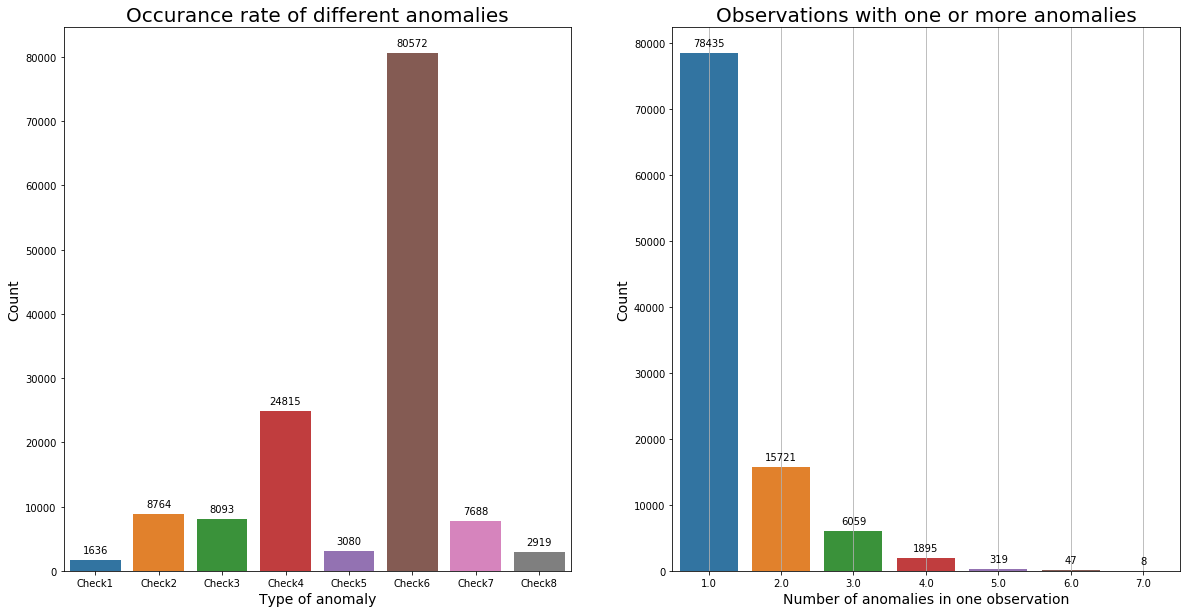

In [21]:
y1 = counted_anomaliesDF.loc[1.0]
x1 = labels

figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

b1 = sns.barplot(y=y1, x=x1, ax=ax1)
plt.grid()

for p in b1.patches:
    b1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

rowSums = dataDF.iloc[:,36:].sum(axis=1)
rowSums = rowSums.value_counts()
multiLabel_counts = rowSums[1:]    

b2 = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, ax=ax2)
plt.grid()

for p in b2.patches:
    b2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_xlabel('Type of anomaly', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Occurance rate of different anomalies', fontsize=20)

ax2.set_xlabel('Number of anomalies in one observation', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_title('Observations with one or more anomalies', fontsize=20)

Here we confirm the infomation retrieved from the description, and in addition we can see that there are relatively few observations that have more than one anomaly. That being said, lets have a look at the linear correlation between the different checks.

Text(0.5,1,'Corrolation matrix of the 8 different checks')

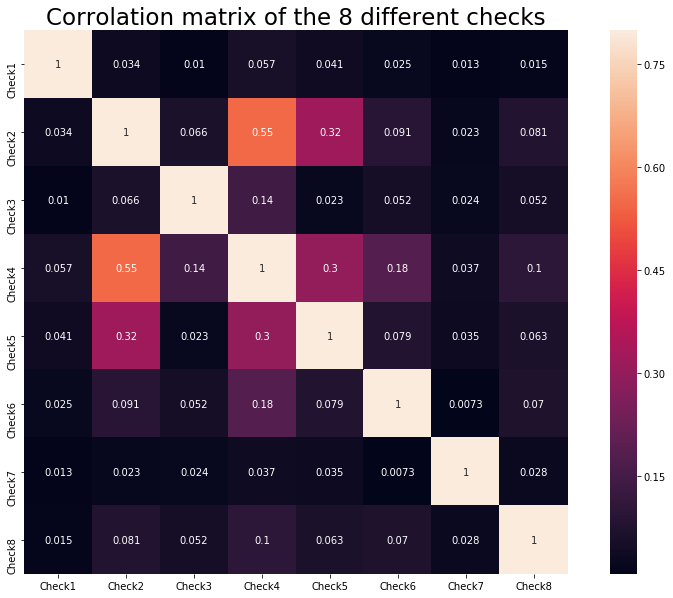

In [22]:
corr_matrix_anomalies = anomaliesDF.corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix_anomalies, vmax=0.8, annot=True, square=True)
plt.title('Corrolation matrix of the 8 different checks', fontsize=23)

From the correlation matrix, we can note three interesting dependencies. 
* Check4 and Check2 have a corrolation of 0.55. 
* Check5 and Check2 have a corrolation of 0.32.
* Check5 and Check4 have a corrolation of 0.3
This might come into play later, as we could check the effect of using the different checks to predict each other. For now we move on to cleaning of the input data. 

### Cleaning

In [49]:
pure_dataDF_with_avgNA.dtypes

SessionNumber                              int64
SystemID                                   int64
Date                                      object
HighPriorityAlerts                         int64
Dumps                                    float64
CleanupOOMDumps                          float64
CompositeOOMDums                         float64
IndexServerRestarts                        int64
NameServerRestarts                         int64
XSEngineRestarts                           int64
PreprocessorRestarts                       int64
DaemonRestarts                             int64
StatisticsServerRestarts                   int64
CPU                                      float64
PhysMEM                                  float64
InstanceMEM                              float64
TablesAllocation                         float64
IndexServerAllocationLimit               float64
ColumnUnloads                              int64
DeltaSize                                float64
MergeErrors         

In [51]:
pure_dataDF_with_avgNA.describe()

,SessionNumber,SystemID,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,PreprocessorRestarts,...,DiagnosisFilesSize,DaysWithSuccessfulDataBackups,DaysWithSuccessfulLogBackups,DaysWithFailedDataBackups,DaysWithFailedfulLogBackups,MinDailyNumberOfSuccessfulDataBackups,MinDailyNumberOfSuccessfulLogBackups,MaxDailyNumberOfFailedDataBackups,MaxDailyNumberOfFailedLogBackups,LogSegmentChange
count,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,...,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00,287031.00
mean,121660.35,634.39,2.80,0.72,0.00,0.17,0.10,0.06,0.05,0.00,...,1962629814.20,5.92,7.68,0.20,0.55,0.99,121.92,0.11,81.02,1.33
std,63902.08,686.66,2.69,12.07,0.00,1.91,1.92,1.19,1.03,0.00,...,19231772740.01,2.72,2.25,0.86,1.53,0.44,144.41,0.47,872.70,111.78
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1514934.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-16887.00
25%,67071.50,106.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,451848876.00,5.00,8.00,0.00,0.00,1.00,36.00,0.00,0.00,0.00
50%,130982.00,340.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,795133287.00,7.00,8.00,0.00,0.00,1.00,102.00,0.00,0.00,0.00
75%,174661.50,958.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1511461843.50,8.00,8.00,0.00,0.00,1.00,134.00,0.00,0.00,0.00
max,228195.00,3187.00,24.00,1429.00,0.00,280.00,341.00,159.00,150.00,0.00,...,1730000000000.00,14.00,22.00,13.00,14.00,17.00,7156.00,63.00,66017.00,10084.00


In the description we can note some strange numbers. A couple of columns have zero variance (e.g. CleanupOOMDumps), meaning that they only contain zeros or NaNs. These will not be usefull for the model, and are therefore removed. Some of the columns have a very low variance meaning that they contain very little data. Some of the columns are in float format, and our rule based model requires them to be integers, so we need to recast them to integers with some preprocessing first.

Below is the code used to analyze every column (we only show one example), and the table in the cell below shows the action we take for each column.

In [27]:
sing_ser = pure_dataDF['DeltaSize']

indices_of_non_zero_elements = list(sing_ser.index[np.logical_and(sing_ser != 0.0, sing_ser != np.nan)])
to_inspect = sing_ser[indices_of_non_zero_elements]

print('Number of non-zero elements:',len(to_inspect), '\n')
start = 100
print(to_inspect[start:start + 5])

Number of non-zero elements: 286677 

100   9596538169.00
101   1787984069.00
102   1496695469.00
103   9569578911.00
104   2575048775.00
Name: DeltaSize, dtype: float64


Below are some short explainations of the different actions, and the table showing which action is taken for the different columns:
* **Remove**: Only zeros and NaNs, do not contribute to model
* **Little_variation**: Little variation in data, may not contribute much to model. The reason for not removing them is that even though they don't vary a lot, they might still be correlated with the different checks.
* **OK**: Can't see anything obviously suspect with the data, and no need for recasting for rule-based model.
* **Direct_recast**: All the numbers are integers, but for some reason they have been casted to float64
* **Format_recast** Values are float or string, and need to be scaled/formatted before they are recast to int

| Column                                |   Action  |
|:--------------------------------------|:----------|
| SessionNumber                         | OK |
| SystemID                              | OK |
| Date                                  | Remove |
| HighPriorityAlerts                    | OK |
| Dumps                                 | Direct_recast |
| CleanupOOMDumps                       | Remove |
| CompositeOOMDums                      | Direct_recast |
| IndexServerRestarts                   | Little_variation |
| NameServerRestarts                    | Little_variation |
| XSEngineRestarts                      | Little_variation |
| PreprocessorRestarts                  | Remove |
| DaemonRestarts                        | Remove |
| StatisticsServerRestarts              | Little_variation |
| CPU                                   | Format_recast |
| PhysMEM                               | Format_recast |
| InstanceMEM                           | Format_recast |
| TablesAllocation                      | Format_recast |
| IndexServerAllocationLimit            | Format_recast |
| ColumnUnloads                         | OK |
| DeltaSize                             | Direct_recast |
| MergeErrors                           | Direct_recast |
| BlockingPhaseSec                      | Direct_recast |
| Disk                                  | Format_recast |
| LargestTableSize                      | Direct_recast |
| LargestPartitionSize                  | Direct_recast |
| DiagnosisFiles                        | Direct_recast |
| DiagnosisFilesSize                    | Direct_recast |
| DaysWithSuccessfulDataBackups         | OK |
| DaysWithSuccessfulLogBackups          | OK |
| DaysWithFailedDataBackups             | OK |
| DaysWithFailedfulLogBackups           | OK |
| MinDailyNumberOfSuccessfulDataBackups | Little_variation |
| MinDailyNumberOfSuccessfulLogBackups  | OK |
| MaxDailyNumberOfFailedDataBackups     | OK |
| MaxDailyNumberOfFailedLogBackups      | OK |
| LogSegmentChange                      | Direct_recast |

Below we reformat, and recast the columns listed in the table above. When recasting the columns in format float64 we round them to two decimals and multiply by 100. The column "Date" is in a timestamp format, we decided to remove it because the time of day was almost always the same in the different observations. It could have been interesting to see if a particular week day had many more anomalies, but it was a bit to cumbersome to implement. Below we preprocess the columns.

In [52]:
# Removal
pure_dataDF_with_avgNA_proc = pure_dataDF_with_avgNA.drop(['Date', 
                                                           'CleanupOOMDumps', 
                                                           'PreprocessorRestarts', 
                                                           'DaemonRestarts'], axis=1)

pure_dataDF_with_negNA_proc = pure_dataDF_with_negNA.drop(['Date', 
                                                           'CleanupOOMDumps', 
                                                           'PreprocessorRestarts', 
                                                           'DaemonRestarts'], axis=1)

# Direct recasting
direct_recast = ['Dumps', 'CompositeOOMDums', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 
                 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 
                 'LogSegmentChange']

for column in direct_recast:
    pure_dataDF_with_avgNA_proc[column] = pure_dataDF_with_avgNA_proc[column].astype(np.int64, errors='ignore')
    pure_dataDF_with_negNA_proc[column] = pure_dataDF_with_negNA_proc[column].astype(np.int64, errors='ignore')

#Format recasting
format_recast = ['CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit', 
                    'Disk']
for column in format_recast:
    pure_dataDF_with_avgNA_proc[column] = 100*pure_dataDF_with_avgNA_proc[column]
    pure_dataDF_with_avgNA_proc[column] = pure_dataDF_with_avgNA_proc[column].astype(np.int64, errors='ignore')
    
    pure_dataDF_with_negNA_proc[column] = 100*pure_dataDF_with_negNA_proc[column]
    pure_dataDF_with_negNA_proc[column] = pure_dataDF_with_negNA_proc[column].astype(np.int64, errors='ignore')

pure_dataDF_with_avgNA_proc.dtypes

SessionNumber                            int64
SystemID                                 int64
HighPriorityAlerts                       int64
Dumps                                    int64
CompositeOOMDums                         int64
IndexServerRestarts                      int64
NameServerRestarts                       int64
XSEngineRestarts                         int64
StatisticsServerRestarts                 int64
CPU                                      int64
PhysMEM                                  int64
InstanceMEM                              int64
TablesAllocation                         int64
IndexServerAllocationLimit               int64
ColumnUnloads                            int64
DeltaSize                                int64
MergeErrors                              int64
BlockingPhaseSec                         int64
Disk                                     int64
LargestTableSize                         int64
LargestPartitionSize                     int64
DiagnosisFile

Now we have the input date in the right format. Let us take a look at the correlation between the different columns in the input data. 

Text(0.5,1,'Corrolation matrix of the input columns')

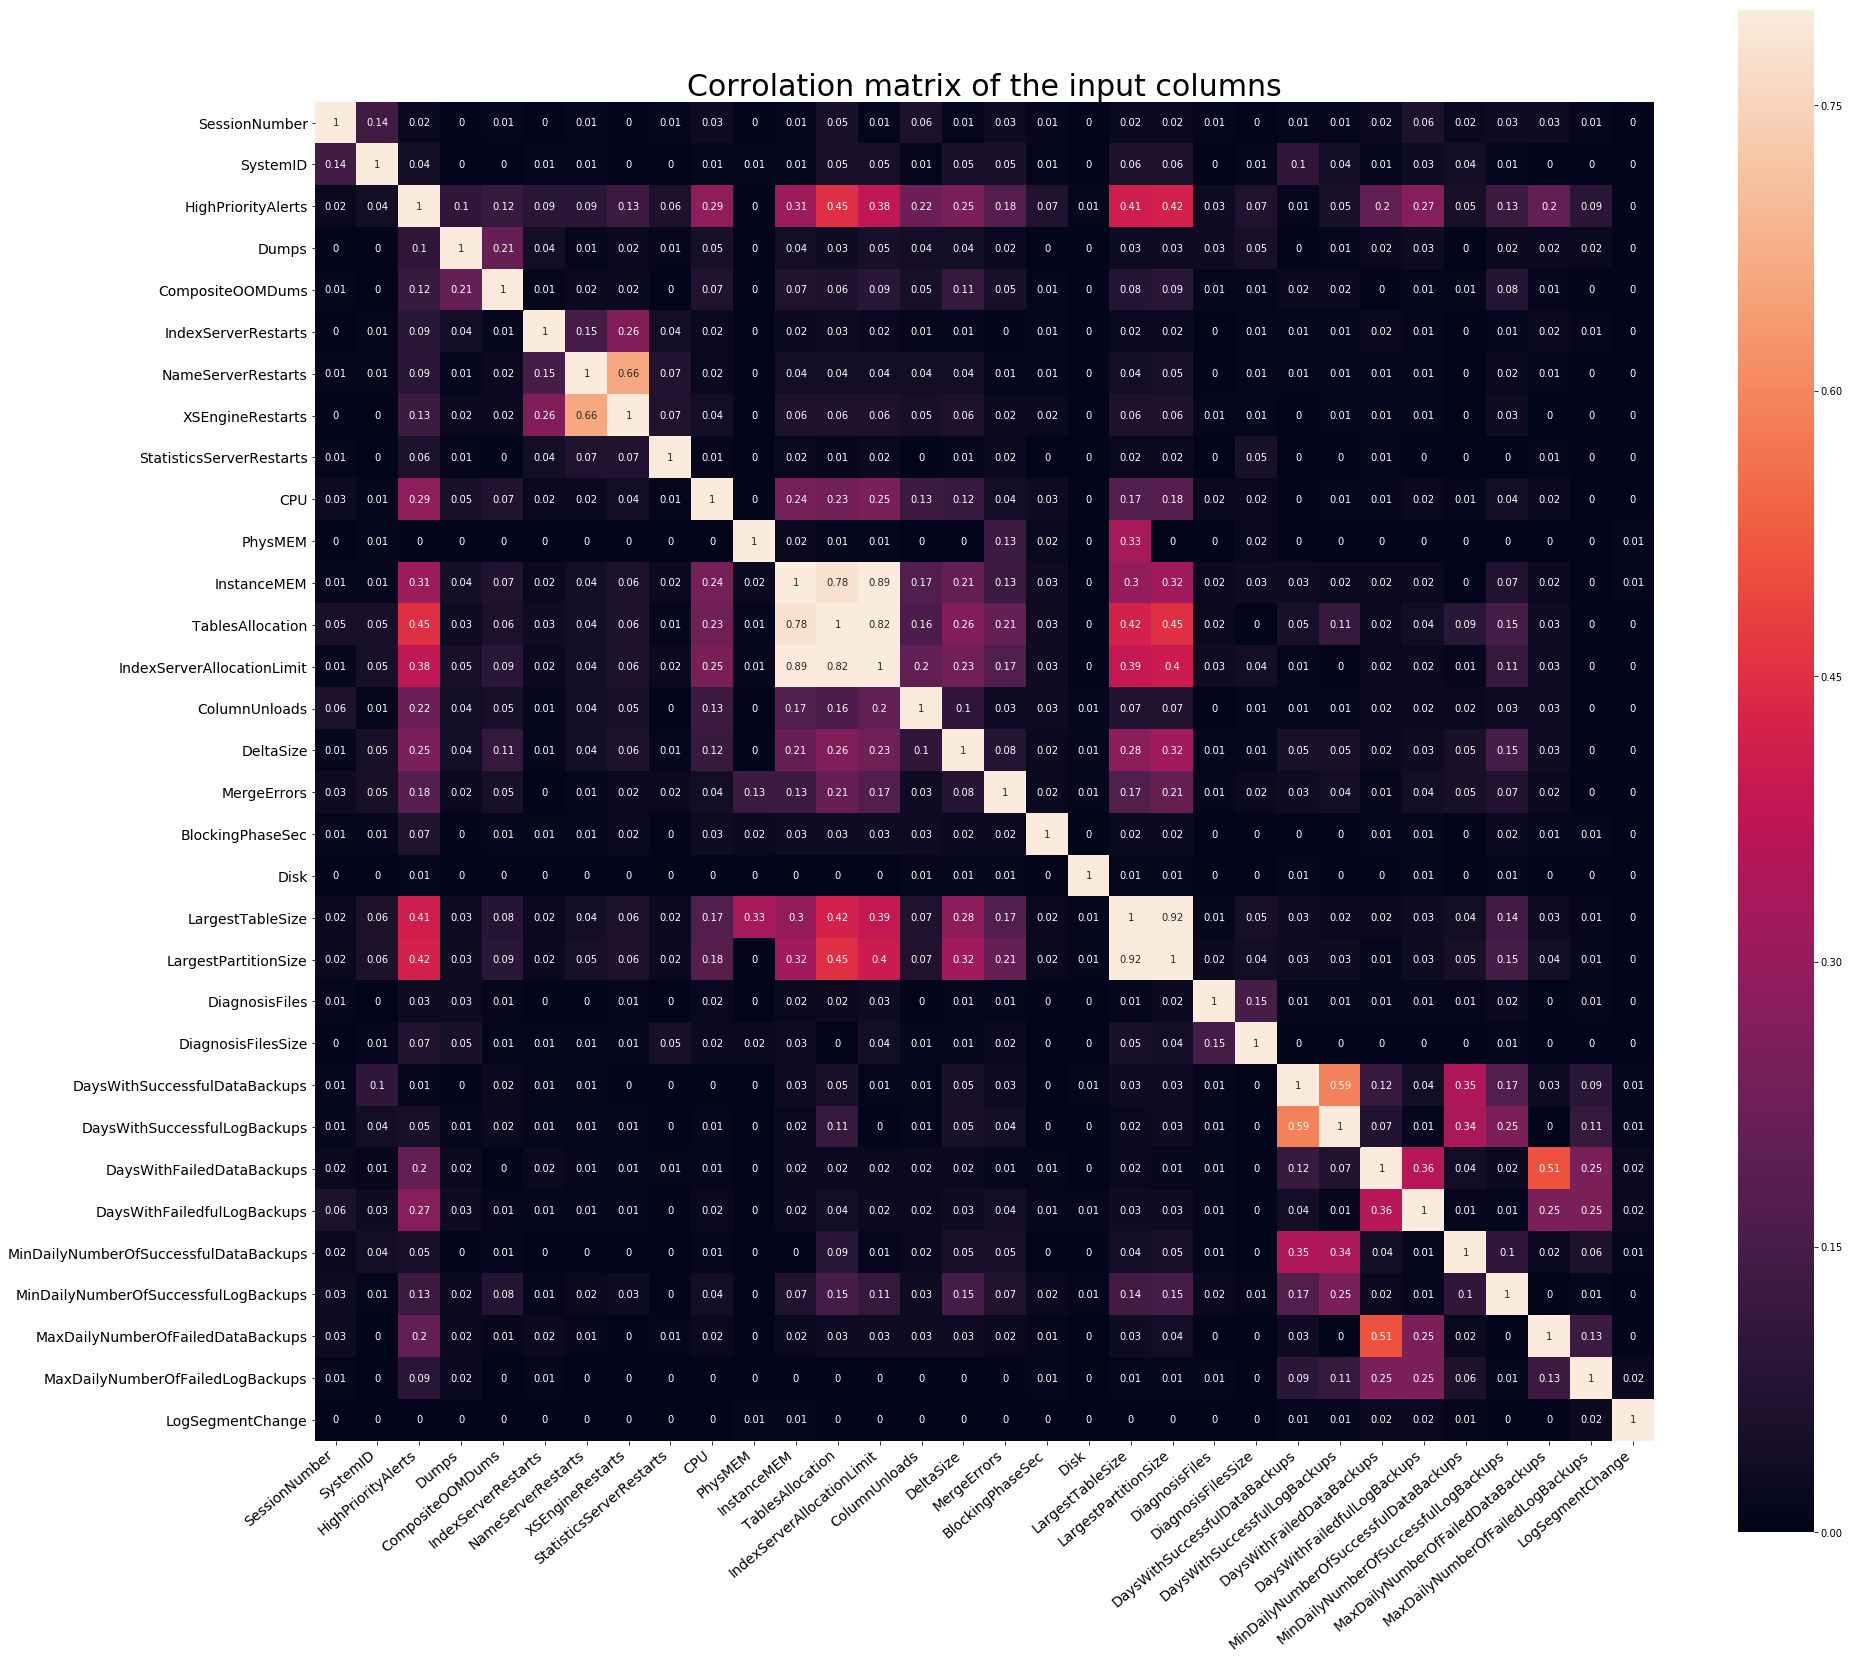

In [65]:
corr_matrix_data = pure_dataDF.drop(['Date', 
                                     'CleanupOOMDumps', 
                                     'PreprocessorRestarts', 
                                     'DaemonRestarts'], axis=1).corr().round(2)

figure, ax = plt.subplots(figsize=(30,28))
ax = sns.heatmap(abs(corr_matrix_data), vmax=0.8, annot=True, square=True)
ax.set_xticklabels(labels=corr_matrix_data.columns, rotation=40, ha='right')

for x_tick in ax.xaxis.get_major_ticks():
    x_tick.label.set_fontsize(14)

for y_tick in ax.yaxis.get_major_ticks():
    y_tick.label.set_fontsize(14)
plt.title('Corrolation matrix of the input columns', fontsize=30)

Here it is worth noting that many of the input columns are higly correlated. We will not go through all of the columns that are significantly correlated, but we will note the pairs that have a correlation above 50%.

* LargestTableSize and LargestPartitionSize are 92% correlated
* IndexServerAllocationLimit and InstanceMEM are 89% correlated
* InstanceMEM and TablesAllocation are 78% correlated
* NameServerRestarts and XSEngineRestarts are 66% correlated
* IndexServerAllocationLimit and TablesAllocation are 82% correlated
* DaysWithSuccessfulLogBackups and DaysWithSuccessfulDataBackups are 59% correlated

Finally we investigate whether there are any of the input columns that are particularily correlated with the different anomalies.

In [68]:
only_check1 = ['Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']
only_check2 = ['Check1', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check3 = ['Check1', 'Check2', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check4 = ['Check1', 'Check2', 'Check3', 'Check5', 'Check6', 'Check7', 'Check8'] 
only_check5 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check6', 'Check7', 'Check8'] 
only_check6 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check7', 'Check8'] 
only_check7 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check8'] 
only_check8 = ['Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7'] 

to_make_corr = dataDF.drop(['Date', 'CleanupOOMDumps', 'PreprocessorRestarts', 'DaemonRestarts'], axis=1)

nr_cols = 10
corr_check1 = to_make_corr.drop(only_check1, axis=1).corr(method='pearson')['Check1'].sort_values(ascending=False)[1:nr_cols]
corr_check2 = to_make_corr.drop(only_check2, axis=1).corr(method='pearson')['Check2'].sort_values(ascending=False)[1:nr_cols]
corr_check3 = to_make_corr.drop(only_check3, axis=1).corr(method='pearson')['Check3'].sort_values(ascending=False)[1:nr_cols]
corr_check4 = to_make_corr.drop(only_check4, axis=1).corr(method='pearson')['Check4'].sort_values(ascending=False)[1:nr_cols]
corr_check5 = to_make_corr.drop(only_check5, axis=1).corr(method='pearson')['Check5'].sort_values(ascending=False)[1:nr_cols]
corr_check6 = to_make_corr.drop(only_check6, axis=1).corr(method='pearson')['Check6'].sort_values(ascending=False)[1:nr_cols]
corr_check7 = to_make_corr.drop(only_check7, axis=1).corr(method='pearson')['Check7'].sort_values(ascending=False)[1:nr_cols]
corr_check8 = to_make_corr.drop(only_check8, axis=1).corr(method='pearson')['Check8'].sort_values(ascending=False)[1:nr_cols]

Text(0.5,1,'Correlation of different columns with Check1')

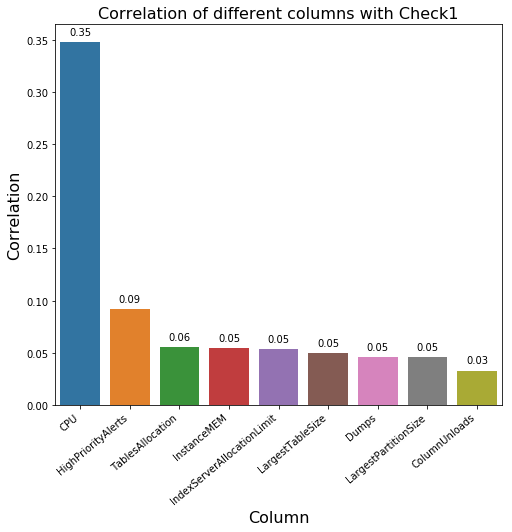

In [76]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check1.index, y=corr_check1.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check1', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check2')

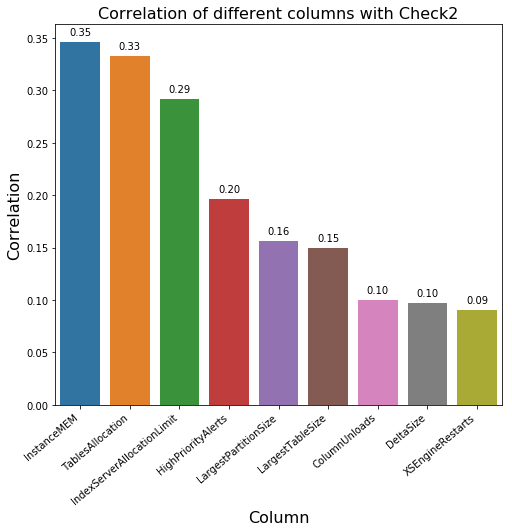

In [77]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check2.index, y=corr_check2.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check2', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check3')

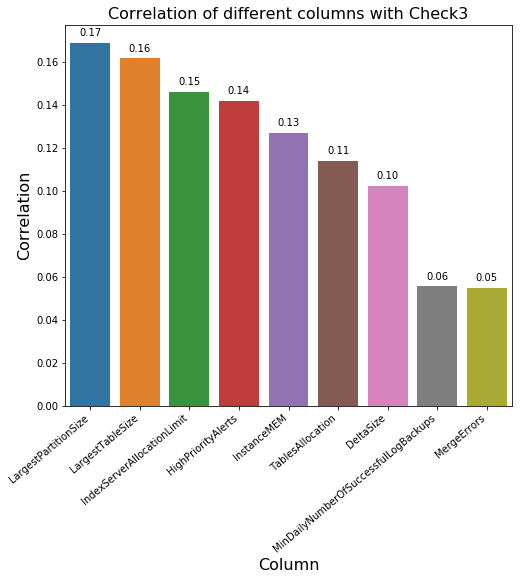

In [78]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check3.index, y=corr_check3.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check3', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check4')

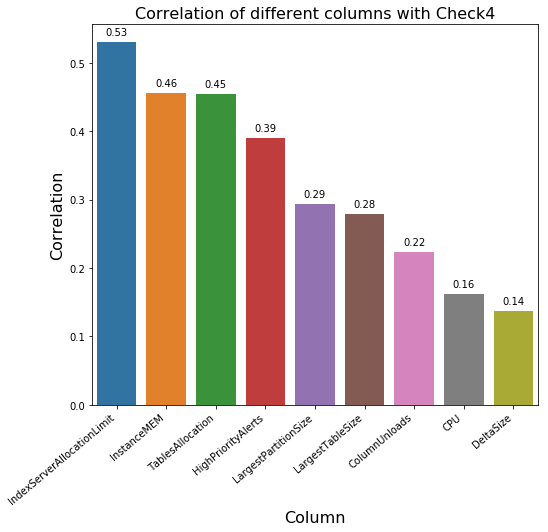

In [79]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check4.index, y=corr_check4.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check4', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check5')

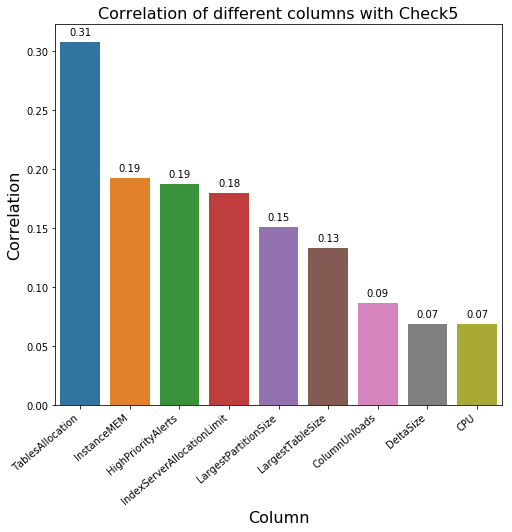

In [80]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check5.index, y=corr_check5.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check5', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check6')

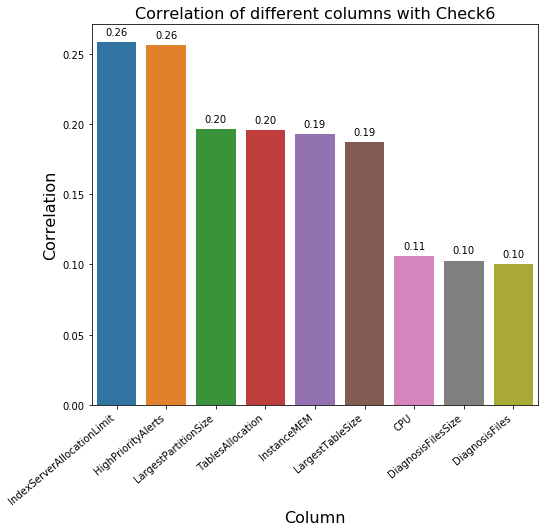

In [81]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check6.index, y=corr_check6.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check6', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check7')

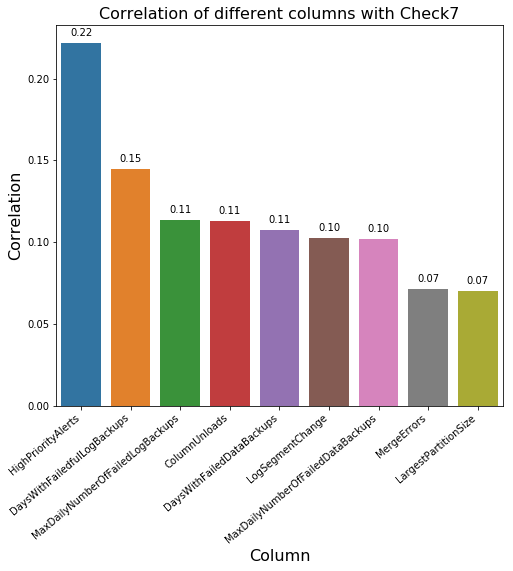

In [82]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check7.index, y=corr_check7.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check7', fontsize=16)

Text(0.5,1,'Correlation of different columns with Check8')

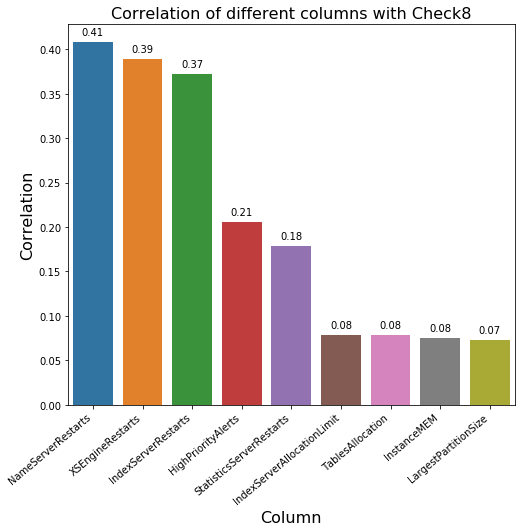

In [83]:
figure, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x=corr_check8.index, y=corr_check8.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel('Column', fontsize= 16)
plt.ylabel('Correlation', fontsize= 16)
plt.title('Correlation of different columns with Check8', fontsize=16)

## Data pre-processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Splitting dataset, while retaining label distribution

## Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Rule based model

### Ensamble of single-label classification models

### Multilabel classification model

## Hyper parameter optimization
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Model Evaluation
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Conclusion
<hr style="height:1px;border:none;color:#333;background-color:#333;" />